In [22]:
def read_student_data(file_path):
    """Read data from csv file and return"""
    students_list = []
    with open(file_path, mode='r') as file:
        headers = file.readline().strip().split(",")
        for line in file:
            student = {}
            values = line.strip().split(",")
            for i, header in enumerate(headers):
                student[header.strip()] = values[i].strip()
                if header.strip() == "CGPA":
                    student[header.strip()] = float(student[header.strip()])

            students_list.append(student)

    return students_list


def pick_student(all_students, tut_grp):
    """pick student out from the tutorial group"""
    students_list = []

    for student in all_students:
        if student['Tutorial Group'] == f'G-{tut_grp}':
            students_list.append(student)

    return students_list


def diverse_team(size_team, sorted_student_more, sorted_student_less):  # size of team, index(0,-1,or middle)
    team = []
    i = 0  # round
    sorted_student = [sorted_student_more, sorted_student_less]

    gender_run_two_time = False
    if size_team % 2 == 0 and len(sorted_student_more) - len(sorted_student_less) >= size_team / 2:
        gender_run_two_time = True

    gender_index = 0

    while len(team) < size_team and (sorted_student[0] or sorted_student[1]):  # add student into team when teams is not full
        index_changes = [+1, -1, +1]
        pick_index = [0, -1, len(sorted_student[gender_index]) // 2]
        while True:
            if not sorted_student[gender_index]:
                break
            elif index_changes[i] >= 0 and pick_index[i] + index_changes[i] < len(sorted_student[gender_index]) and index_changes[
                i] <= 5:
                # Check if school is not in the team
                if sorted_student[gender_index][pick_index[i] + index_changes[i]]['School'] not in [student['School'] for student in
                                                                                                    team]:
                    team.append(sorted_student[gender_index].pop(pick_index[i] + index_changes[i]))
                    break
                else:
                    index_changes[i] += 1
            elif index_changes[i] < 0 and abs(pick_index[i] + index_changes[i]) <= len(sorted_student[gender_index]) and abs(
                    index_changes[i]) <= 5:
                # Check if school is not in the team
                if sorted_student[gender_index][pick_index[i] + index_changes[i]]['School'] not in [student['School'] for student in
                                                                                                    team]:
                    team.append(sorted_student[gender_index].pop(pick_index[i] + index_changes[i]))
                    break
                else:
                    index_changes[i] -= 1
            else:
                # If the index exceeds the list length, reset index_changes or break
                team.append(sorted_student[gender_index].pop(pick_index[i]))
                break

        i += 1
        gender_index += 1
        if i > 2:
            i = 0
        if gender_index > 1 or gender_run_two_time:
            gender_index = 0
            gender_run_two_time = False

    return team


def division_into_team(students_list, size):
    """Divides student from student_list into group of size with balance of cgpa and gender, and diverse of school"""
    # Separate male and female students into two lists
    male_students = [student for student in students_list if student['Gender'] == 'Male']
    female_students = [student for student in students_list if student['Gender'] == 'Female']

    # Sort the male and female students by CGPA
    male_sorted_students = sorted(male_students, key=lambda student: student['CGPA'])
    female_sorted_students = sorted(female_students, key=lambda student: student['CGPA'])

    teams = [[] for _ in range(len(students_list) // size)]
    team_index = 0

    while team_index < len(teams):  # while haven't added student into all teams
        if len(male_sorted_students) >= len(female_sorted_students):  # if remain male student more than remain female student
            teams[team_index] = diverse_team(size, male_sorted_students, female_sorted_students)

        else:  # if remain male student less than remain female student
            teams[team_index] = diverse_team(size, female_sorted_students, male_sorted_students)

        team_index += 1

    first_run = True
    while male_sorted_students or female_sorted_students:
        for team in teams:
            male = sum(1 for student in team if student['Gender'] == 'Male')
            female = sum(1 for student in team if student['Gender'] == 'Female')

            # Handle male students first
            if male_sorted_students:
                if male > female:
                    continue
                elif female > male:
                    team.append(male_sorted_students.pop(0))
                    continue
                elif not first_run and male - female < 2:
                    team.append(male_sorted_students.pop(0))
                    continue

            # Handle female students
            if female_sorted_students:
                if male > female:
                    team.append(female_sorted_students.pop(0))
                    continue
                elif female > male:
                    continue
                elif not first_run and female - male < 2:
                    team.append(female_sorted_students.pop(0))
                    continue

        if not first_run:
            break

        # Mark the first run complete
        first_run = False

    return teams


def see_group_division(group_division): # i changed abit here. its just for printing. 
    unique_school_counts = [0] * 18  # Assuming a maximum of 18 schools
    
    for i, team in enumerate(group_division):
        print(f"Group {i}")
        
        cgpa = 0
        schools_in_team = set()  # Create a set to track unique schools
        
        for student in team:
            print(student["Student ID"], student["School"], student["CGPA"])
            cgpa += student["CGPA"]
            schools_in_team.add(student["School"])  # Add school to the set
        
        mean_cgpa = cgpa / len(team)  # Calculate mean CGPA
        unique_schools_count = len(schools_in_team)  # Count of unique schools
        
        print(f"Mean CGPA of this team is {mean_cgpa:.2f}")
        print(f"Number of unique schools in this team: {unique_schools_count}")
        print()
        
        # Count the number of unique schools
        if unique_schools_count > 0:
            unique_school_counts[unique_schools_count - 1] += 1  # Increment the count for this number of unique schools
    
    # Print summary of unique schools across all teams
    print("Summary of Unique Schools Count:")
    for count in range(1, len(unique_school_counts) + 1):
        print(f"{count} unique school(s): {unique_school_counts[count - 1]} team(s)")

# Assuming you have your group_division variable from previous code
see_group_division(group_division)


students = read_student_data('records.csv')
group_division = []
tutorial_grp = 1
team_size = 6  # can adjust

while tutorial_grp <= 150:
    group_division.extend(division_into_team(pick_student(students, tutorial_grp), team_size))
    tutorial_grp += 1

see_group_division(group_division)

with open("group-advanced.txt", mode="w") as f:
    for i, x in enumerate(group_division):
        f.write(f"Group {i}\n")
        cgpa = 0
        for j in x:
            l = f"{j['Student ID'], j['School'], j['CGPA'], j['Gender']}\n"
            f.write(l)
            cgpa += j["CGPA"]
        f.write(f" the mean cgpa of this group is {cgpa / len(x)}\n")
        f.write("\n")

Group 0
2353 SBS 3.95
2091 EEE 4.2
592 MSE 4.11
1645 CoE 3.93
2069 SSS 4.48
1075 CoB (NBS) 4.08
4563 WKW SCI 4.01
Mean CGPA of this team is 4.11
Number of unique schools in this team: 7

Group 1
2326 CoB (NBS) 3.95
3989 WKW SCI 4.15
5703 SPMS 4.12
3148 EEE 3.88
4820 CoE 4.22
5477 SoH 4.09
75 CCDS 4.03
Mean CGPA of this team is 4.06
Number of unique schools in this team: 7

Group 2
2151 EEE 4.02
2776 CCEB 4.14
1271 SSS 4.17
4657 SoH 4.0
809 CoB (NBS) 4.26
1417 CoE 4.12
5119 ADM 4.04
Mean CGPA of this team is 4.11
Number of unique schools in this team: 7

Group 3
2115 EEE 4.03
1841 MAE 4.12
2230 CoB (NBS) 4.18
5002 CCDS 4.02
4338 SPMS 4.22
5708 SoH 4.2
162 SSS 4.07
Mean CGPA of this team is 4.12
Number of unique schools in this team: 7

Group 4
567 CoB (NBS) 4.03
3628 EEE 4.06
71 SoH 4.19
588 MAE 4.06
659 SSS 4.2
235 CCDS 4.06
2417 SSS 3.88
Mean CGPA of this team is 4.07
Number of unique schools in this team: 6

Group 5
3838 EEE 4.05
2818 CoB (NBS) 4.09
3861 ASE 4.52
1329 NIE 3.85
4479 C

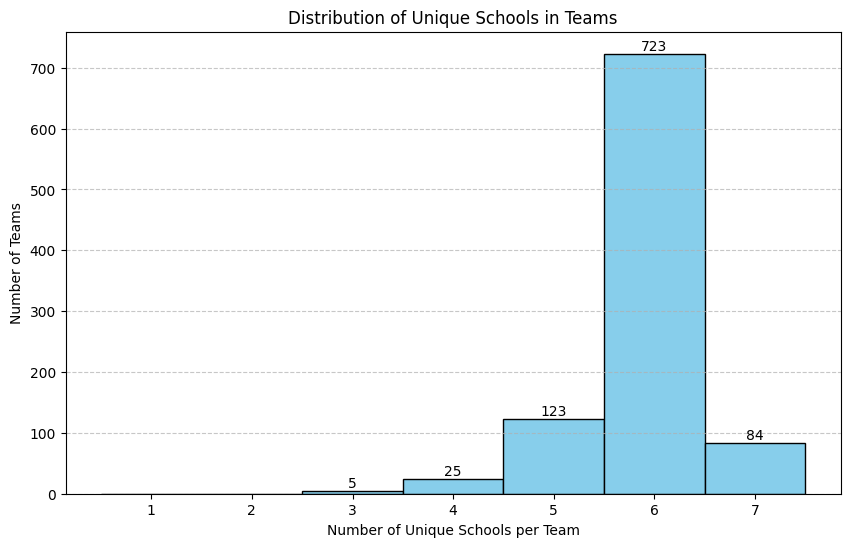

In [23]:
import matplotlib.pyplot as plt

def count_unique_schools_per_team(group_division):
    """Count the number of unique schools in each team."""
    unique_school_counts = []

    for team in group_division:
        schools_in_team = {student['School'] for student in team}  # Use a set to get unique schools
        unique_school_counts.append(len(schools_in_team))  # Count of unique schools

    return unique_school_counts

def visualize_unique_school_distribution(unique_school_counts):
    """Visualize the distribution of unique schools in teams as a histogram."""
    plt.figure(figsize=(10, 6))
    
    # Set the bins to be the actual number of unique schools
    counts, bins, patches = plt.hist(unique_school_counts, bins=range(1, max(unique_school_counts) + 2), 
                                      color='skyblue', edgecolor='black', align='left')
    
    plt.xticks(range(1, max(unique_school_counts) + 1))  # Set x-ticks to only the unique school counts
    plt.xlabel("Number of Unique Schools per Team")
    plt.ylabel("Number of Teams")
    plt.title("Distribution of Unique Schools in Teams")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add the count labels above the bars
    for count, bin in zip(counts, bins):
        if count > 0:  # Only add labels for bars with a count
            plt.text(bin + 0, count, int(count), ha='center', va='bottom')

    plt.show()

# Assuming you have your group_division variable from previous code
unique_school_counts = count_unique_schools_per_team(group_division)
visualize_unique_school_distribution(unique_school_counts)

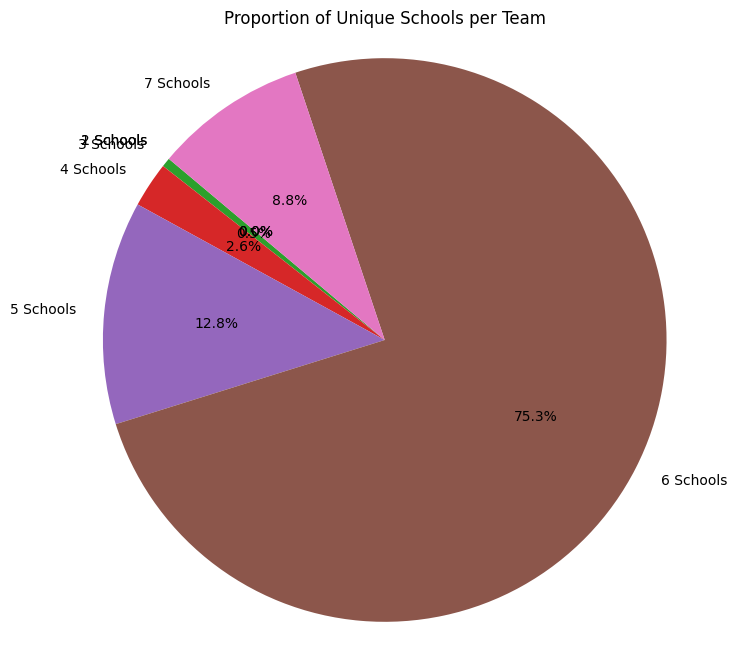

In [24]:
def visualize_unique_school_pie_chart(unique_school_counts):
    """Visualize the proportion of unique schools in teams as a pie chart."""
    school_count_distribution = [unique_school_counts.count(i) for i in range(1, max(unique_school_counts) + 1)]
    labels = [f"{i} Schools" for i in range(1, max(unique_school_counts) + 1)]

    plt.figure(figsize=(8, 8))
    plt.pie(school_count_distribution, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Proportion of Unique Schools per Team")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Assuming you have your group_division variable from previous code
unique_school_counts = count_unique_schools_per_team(group_division)
visualize_unique_school_pie_chart(unique_school_counts)